<a href="https://colab.research.google.com/github/bhuwanaryal19/nepali_digit_recognizer/blob/master/Nepali_Digits_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Change runtime to GPU for faster compuatation

# Prepare the dataset
Download dataset from [this url](https://archive.ics.uci.edu/ml/machine-learning-databases/00389/). 

In [0]:
# get dataset from url
! wget -qq https://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip

# unzip zip files
!unzip -q DevanagariHandwrittenCharacterDataset.zip

# rename directory
!mv DevanagariHandwrittenCharacterDataset/ data/ 
# remove .zip file
!rm *.zip

#Load libraries 

In [0]:
# import libraries
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, callbacks, optimizers, models

In [0]:
# for this problem i'll consider only digits
class_names = [f'digit_{i}' for i in range(10)]

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,)
test_datagen = ImageDataGenerator(rescale=1./255)

In [52]:
train_digits_loader = train_datagen.flow_from_directory(
        'data/Train',
        target_size=(32, 32),
        classes = class_names,
        batch_size=32,
        color_mode = 'grayscale',
        class_mode='categorical')

test_digits_loader = test_datagen.flow_from_directory(
        'data/Test',
        target_size=(32, 32),
        classes = class_names,
        color_mode = 'grayscale',
        batch_size=1,
        shuffle = False,
        seed = 2076,
        class_mode='categorical')

Found 17000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


# Visualize Data

In [0]:
def plot_image(img_path_index):
  img_path = train_digits_loader.filepaths[img_path_index]
  a = Image.open(img_path)
  arr = np.array(a)
  plt.imshow(arr,cmap= 'gray')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])


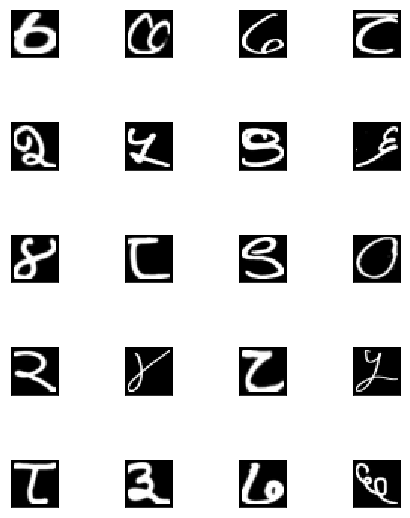

In [54]:
# plot 20 random images from our training set
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  rand_index = random.randint(1,17000)
  plot_image(rand_index)
plt.show()

# Model Building and training

In [0]:
# let's create a base model
def cnn_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64,(3,3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  opt = optimizers.Adam(lr=0.0015, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [56]:
model = cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                65600     
__________

In [0]:
# callbacks for saving models
filepath = 'cnn-{val_acc: 5.3f}.h5'
model_save = callbacks.ModelCheckpoint(filepath, monitor= 'val_acc', save_best_only=True)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience =4)

In [0]:
def plot_acc(history):
  plt.plot(history.epoch, history.history['val_acc'] )
  plt.plot(history.epoch, history.history['acc'])
  plt.legend(['val_acc', 'train acc'])


In [59]:
sample_size = train_digits_loader.n
batch_size = 32

hist = model.fit_generator(
    train_digits_loader,
    steps_per_epoch=sample_size // batch_size,
    epochs=50,
    validation_data=test_digits_loader,
    validation_steps=3000 ,
    callbacks=[model_save, early_stop]
)

Epoch 1/50
531/531 [==============================] - 35s 66ms/step - loss: 0.2625 - acc: 0.9131 - val_loss: 0.0544 - val_acc: 0.9860
Epoch 2/50
531/531 [==============================] - 35s 67ms/step - loss: 0.0509 - acc: 0.9852 - val_loss: 0.0447 - val_acc: 0.9883
Epoch 3/50
531/531 [==============================] - 37s 69ms/step - loss: 0.0274 - acc: 0.9915 - val_loss: 0.0333 - val_acc: 0.9917
Epoch 4/50
531/531 [==============================] - 35s 65ms/step - loss: 0.0202 - acc: 0.9935 - val_loss: 0.0398 - val_acc: 0.9907
Epoch 5/50
531/531 [==============================] - 36s 68ms/step - loss: 0.0129 - acc: 0.9963 - val_loss: 0.0334 - val_acc: 0.9913
Epoch 6/50
531/531 [==============================] - 35s 66ms/step - loss: 0.0089 - acc: 0.9971 - val_loss: 0.0295 - val_acc: 0.9937
Epoch 7/50
531/531 [==============================] - 36s 68ms/step - loss: 0.0078 - acc: 0.9975 - val_loss: 0.0290 - val_acc: 0.9930
Epoch 8/50
531/531 [==============================] - 34s 64ms

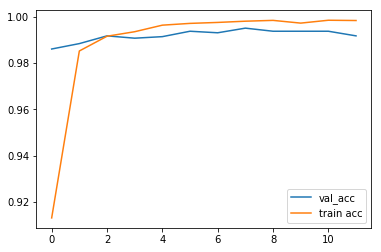

In [60]:
plot_acc(hist)

# Model loading and evaluation

In [0]:
classifier = models.load_model('cnn- 0.995.h5')

In [63]:
classifier.evaluate_generator(test_digits_loader, steps = 3000)

[0.023661077855737612, 0.995]

In [0]:
# lets test for our test data
test_digits_loader.reset()
true_labels = test_digits_loader.classes
predictions_with_prob = classifier.predict_generator(test_digits_loader, steps = 3000)

In [0]:
predictions = np.argmax(predictions_with_prob, axis= 1)

In [0]:
incorrect_predictions = np.nonzero(predictions - true_labels)

In [76]:
incorrect_predictions

(array([ 428,  752,  910,  949, 1047, 1177, 1208, 1445, 1771, 1965, 1967,
        2090, 2116, 2709, 2993]),)

In [82]:
for _ in range(10):
  rand_index = random.randint(0,3000)
  print(f'True label: {true_labels[rand_index]} , Predicted labe: {predictions[rand_index]} for index {rand_index}')

True label: 8 , Predicted labe: 8 for index 2481
True label: 3 , Predicted labe: 3 for index 993
True label: 5 , Predicted labe: 5 for index 1706
True label: 3 , Predicted labe: 3 for index 963
True label: 7 , Predicted labe: 7 for index 2376
True label: 4 , Predicted labe: 4 for index 1480
True label: 2 , Predicted labe: 2 for index 768
True label: 3 , Predicted labe: 3 for index 1032
True label: 6 , Predicted labe: 6 for index 1862
True label: 9 , Predicted labe: 9 for index 2931


In [0]:
# function to plot image with predictions percentages
def plot_predicted_image(i, predictions_array, true_labels, img_generator):
  predicted_label, true_label, img = predictions_array[i], true_labels[i], img_generator[i][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  reshaped_img = img.reshape(32,32)
  plt.imshow(reshaped_img, cmap=plt.cm.binary)
  plt.title(f' Predicted {true_label } for {predicted_label}  digit')


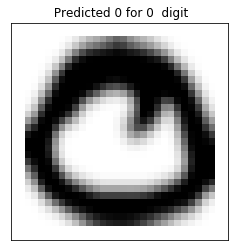

In [91]:
plot_predicted_image(100, predictions, true_labels, test_digits_loader)

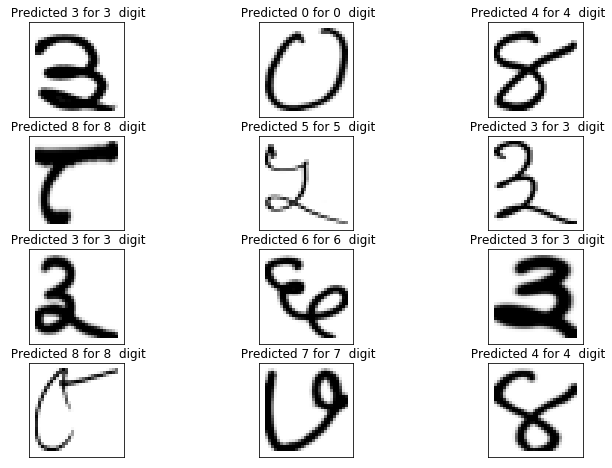

In [99]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  rand_idx = random.randint(0,3000)
  plot_predicted_image(rand_idx, predictions, true_labels, test_digits_loader)
plt.show()

# Let's plot our incorrect prediction

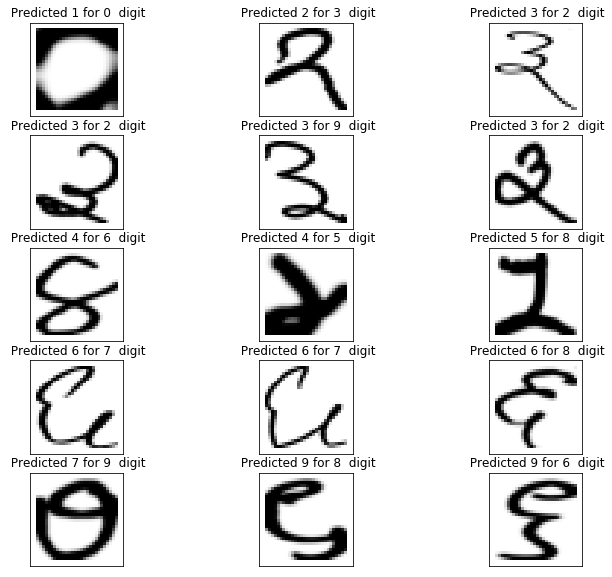

In [101]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  plot_predicted_image(incorrect_predictions[0][i], predictions, true_labels, test_digits_loader)
plt.show()

It looks like our dataset has some mislabels. We can remove those to get better models.